In [91]:
# Import libraries
import requests
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

In [3]:
# reads in bitcoin data from a downloaded csv file
bitcoin = pd.read_csv("C:\\Qilin\\Python\\CryptoReturnsModelling\\btc-usd-max.csv")

# modifies indexes to get rid of timezone format and reindex to given values in csv
bitcoin['snapped_at'] = pd.to_datetime(bitcoin.snapped_at).dt.tz_localize(None)
bitcoin.index = bitcoin['snapped_at']

# resamples data to last of the month
bitcoin = bitcoin.resample('M').last()

# deletes original index reference column and creates returns column
del bitcoin['snapped_at']
bitcoin['Returns'] = bitcoin['price'].pct_change().cumsum().fillna(0).multiply(100)

# display data
bitcoin.head()

,price,market_cap,total_volume,Returns
snapped_at,,,,
2013-04-30,135.3000,1.501657e+09,0.0,0.000000
2013-05-31,127.9800,1.436387e+09,0.0,-5.410200
2013-06-30,95.3886,1.082694e+09,0.0,-30.876210
2013-07-31,110.3400,1.267183e+09,0.0,-15.202010
2013-08-31,137.7600,1.602407e+09,0.0,9.648452


In [140]:
# The CoinDesk 20
coindesk_20 = ['BTC', 'ETH', 'XRP', 'ADA', 'USDT', 'DOGE', 
               'XLM', 'DOT', 'UNI', 'LINK', 'USDC', 'BCH', 
               'LTC', 'GRT', 'ETC', 'FIL', 'AAVE', 'ALGO', 'EOS']

# Setting dataframes
raw_df = pd.DataFrame()
for coin in coindesk_20:
    # individual coin dataframe
    df = pd.DataFrame(index=[0])
    
    # Define start and end times
    enddate = datetime(2022, 3, 19, 0, 0)
    startdate = datetime(2013, 1, 1, 0, 0)
    
    # get url based on start and end
    url = 'https://production.api.coindesk.com/v2/price/values/' + coin + '?start_date=' + \
            startdate.strftime("%Y-%m-%dT%H:%M") + \
            '&end_date=' + enddate.strftime("%Y-%m-%dT%H:%M") + '&ohlc=false'
    
    # request json data
    temp_data_json = requests.get(url)
    temp_data = temp_data_json.json()
    df = pd.DataFrame(temp_data['data']['entries'])
    df.columns = ['Timestamp', 'Close']
    
    # redo timestamp labelling
    df = df.drop(['Timestamp'], axis=1)
    # loops values by end date
    df['Datetime'] = [enddate - relativedelta(days=len(df)-i) for i in range(0, len(df))]
    df['Datetime'] = pd.to_datetime(df.Datetime).dt.tz_localize(None)
    df.index = pd.to_datetime(df['Datetime'])
    
    # resamples the data monthly and then indexes to match bitcoin index
    df = df.resample('M').first()
    
    # sets symbol column to coin name and adds df to overall
    df['Symbol'] = coin
    raw_df = raw_df.append(df)

# creates pivot table with new columns of symbol and values of close
raw_df = raw_df[['Datetime', 'Symbol', 'Close']]
crypto_df = raw_df.pivot(index='Datetime', columns='Symbol', values='Close')

In [141]:
# writes output to csv
out_path = r"C:\Qilin\Python\CryptoReturnsModelling\out\CoinDesk20.csv"
crypto_df.to_csv(out_path)

In [162]:
# gets data from saved excel
in_path = r"C:\Qilin\Python\CryptoReturnsModelling\out\CoinDesk20.csv"
df = pd.read_csv(in_path)
df.index = pd.to_datetime(df['Datetime'])
df = df.drop(['Datetime'], axis=1)

# creates coin-returns list to average all
coin_returns = []
for coin in df:
    name = coin + '_returns'
    df[name] = df[coin].pct_change().multiply(100).cumsum()
    
    # excludes stable coins
    if df[name].iloc[-1] < 10:
        continue
    coin_returns.append(name)
df['avgReturns'] = df[coin_returns].mean(axis=1)
print(df)

                  AAVE       ADA      ALGO         BCH           BTC  \
Datetime                                                               
2013-10-01         NaN       NaN       NaN         NaN    123.654990   
2013-11-01         NaN       NaN       NaN         NaN    198.048830   
2013-12-01         NaN       NaN       NaN         NaN   1099.519260   
2014-01-01         NaN       NaN       NaN         NaN    768.407830   
2014-02-01         NaN       NaN       NaN         NaN    847.363830   
...                ...       ...       ...         ...           ...   
2021-11-01  321.937404  1.969538  1.853885  598.203677  62302.705092   
2021-12-01  245.556194  1.722324  1.889355  567.432581  56888.857892   
2022-01-01  265.870280  1.373664  1.672446  446.805234  47372.770076   
2022-02-01  153.248123  1.037321  0.936375  281.695925  37216.137033   
2022-03-01  139.342621  0.943838  0.827616  321.077935  44124.921711   

                DOGE        DOT       EOS        ETC          E

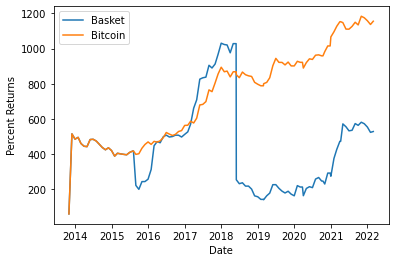

In [163]:
# plots basket returns in blue
plt.plot(df['avgReturns'], label="Basket")

# plots bitcoin returns in orange
plt.plot(df['BTC_returns'], label="Bitcoin")

# relabels axes and creates legend
plt.xlabel("Date")
plt.ylabel("Percent Returns")
plt.legend()

# save figure
outgraph = r"C:\Qilin\Python\CryptoReturnsModelling\out\Returns.png"
plt.savefig(outgraph)

plt.show()

In [197]:
# now we rebalance with top 5 performers each month
def portfolio(data, numStocks):
    df = data.copy()
    
    avg_returns = []
    top = []
    # loops through each row
    for i in range(len(df)):
        # for the first couple rows there will be less than 5 coins
        # in that case we take the mean of those coins performances
        if df.iloc[i,:].count() < 5:
            avg_returns.append(df.iloc[i,:].mean())
        
        # otherwise we take the mean of the top 5 from the previous month
        else: 
            avg_returns.append(df[top].iloc[i,:].mean())
        
        # create new top 5 for next month
        top = df.iloc[i,:].sort_values(ascending=False)[:numStocks].index.values.tolist()
        
    returns_df = pd.DataFrame(np.array(avg_returns), columns=['monthly_returns'], index=df.index)
    return returns_df

# gets data from saved excel
in_path = r"C:\Qilin\Python\CryptoReturnsModelling\out\CoinDesk20.csv"
data = pd.read_csv(in_path)
data.index = pd.to_datetime(data['Datetime'])
data = data.drop(['Datetime'], axis=1)

# adds in columns of noncumulative monthly returns
for coin in data:
    name = coin + '_returns'
    df[name] = data[coin].pct_change().multiply(100)

# driver code
topFive = portfolio(data, 5)
topFive['CAGR'] = topFive['monthly_returns'].cumsum()
print(topFive)

            monthly_returns           CAGR
Datetime                                  
2013-10-01       123.654990     123.654990
2013-11-01       198.048830     321.703820
2013-12-01      1099.519260    1421.223080
2014-01-01       768.407830    2189.630910
2014-02-01       847.363830    3036.994740
...                     ...            ...
2021-11-01     13542.654155  199545.783509
2021-12-01     12493.274309  212039.057819
2022-01-01     10413.590064  222452.647882
2022-02-01      8091.294682  230543.942564
2022-03-01      9533.196015  240077.138580

[111 rows x 2 columns]


This looks really suspicious but considering the explosive performance of cryptocurrencies is not out of consideration. It is still a work in progress and will be optimized to be more realistic

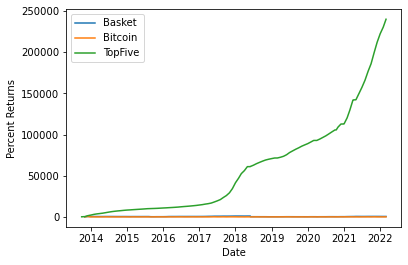

In [198]:
# Comparing rebalanced 5 to bitcoin and previous basket
# plots basket returns in blue
plt.plot(df['avgReturns'], label="Basket")

# plots bitcoin returns in orange
plt.plot(df['BTC_returns'], label="Bitcoin")

# plots rebalanced in green
plt.plot(topFive['CAGR'], label='TopFive')

# relabels axes and creates legend
plt.xlabel("Date")
plt.ylabel("Percent Returns")
plt.legend()

# save figure
outgraph = r"C:\Qilin\Python\CryptoReturnsModelling\out\Returns.png"
plt.savefig(outgraph)

plt.show()